<a href="https://colab.research.google.com/github/rabnawaz172/Diabetic-Retinopathy/blob/main/Dr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
base_path = '/content/drive/My Drive/Diabetic_Retino/PreProcessed/'

In [ ]:
import os

# Define paths to train, validation, and test datasets
base_path = '/content/drive/My Drive/Diabetetic_Retino/preprocced/'
train_path = os.path.join(base_path, 'train')

test_path = os.path.join(base_path, 'test')


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        for filename in tqdm(os.listdir(class_folder)):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize images to 224x224
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)

# Load train, validation, and test datasets
X_train, y_train = load_images_from_folder(train_path)

X_test, y_test = load_images_from_folder(test_path)


100%|██████████| 30/30 [00:00<00:00, 116.22it/s]


In [ ]:
!pip install scikit-image --upgrade

In [ ]:
from tensorflow.keras.applications import VGG16
# Updated import statement
from skimage.feature import graycomatrix, graycoprops
import cv2
import numpy as np
from tqdm import tqdm

# Extract CNN features
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_features_train = base_model.predict(X_train)

cnn_features_test = base_model.predict(X_test)

# Extract GLCM features
def extract_glcm_features(images):
    glcm_features = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Updated function names from greycomatrix/greycoprops to graycomatrix/graycoprops
        glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        glcm_features.append([contrast, homogeneity])
    return np.array(glcm_features)

glcm_features_train = extract_glcm_features(X_train)

glcm_features_test = extract_glcm_features(X_test)


153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


In [ ]:
base_model.summary

<bound method Model.summary of <Functional name=vgg16, built=True>>

In [ ]:
# Combine CNN and GLCM features
def combine_features(cnn_features, glcm_features):
    return np.concatenate((cnn_features.reshape(cnn_features.shape[0], -1), glcm_features), axis=1)

X_train_combined = combine_features(cnn_features_train, glcm_features_train)

X_test_combined = combine_features(cnn_features_test, glcm_features_test)

# Train model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfr = RandomForestClassifier(n_estimators=100, random_state=42)
rfr.fit(X_train_combined, y_train)



# Evaluate model on test set
y_test_pred = rfr.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proleferate  DR', 'Severe']))


Test Set Evaluation:
                 precision    recall  f1-score   support

           Mild       0.94      1.00      0.97        30
       Moderate       0.94      0.97      0.95        30
          No DR       1.00      1.00      1.00        30
Proleferate  DR       1.00      0.97      0.98        30
         Severe       1.00      0.93      0.97        30

       accuracy                           0.97       150
      macro avg       0.97      0.97      0.97       150
   weighted avg       0.97      0.97      0.97       150



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Train Decision Tree model
dtr = DecisionTreeClassifier(random_state=42)
dtr.fit(X_train_combined, y_train)

# Evaluate model on test set
y_test_pred = dtr.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))


Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.94      1.00      0.97        30
      Moderate       0.88      0.97      0.92        30
         No DR       1.00      1.00      1.00        30
Proliferate DR       1.00      0.90      0.95        30
        Severe       1.00      0.93      0.97        30

      accuracy                           0.96       150
     macro avg       0.96      0.96      0.96       150
  weighted avg       0.96      0.96      0.96       150



In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Train Gaussian Naive Bayes (GNB) model
gnb = GaussianNB()
gnb.fit(X_train_combined, y_train)

# Evaluate model on test set
y_test_pred = gnb.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))



Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.71      0.67      0.69        30
      Moderate       0.57      1.00      0.72        30
         No DR       0.87      0.87      0.87        30
Proliferate DR       1.00      0.57      0.72        30
        Severe       0.95      0.70      0.81        30

      accuracy                           0.76       150
     macro avg       0.82      0.76      0.76       150
  weighted avg       0.82      0.76      0.76       150



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression Classifier
logreg = LogisticRegression(max_iter=500, random_state=42, multi_class='multinomial')
logreg.fit(X_train_combined, y_train)

# Evaluate model on test set
y_test_pred = logreg.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       1.00      0.97      0.98        30
      Moderate       0.94      0.97      0.95        30
         No DR       1.00      1.00      1.00        30
Proliferate DR       0.97      0.97      0.97        30
        Severe       0.97      0.97      0.97        30

      accuracy                           0.97       150
     macro avg       0.97      0.97      0.97       150
  weighted avg       0.97      0.97      0.97       150



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


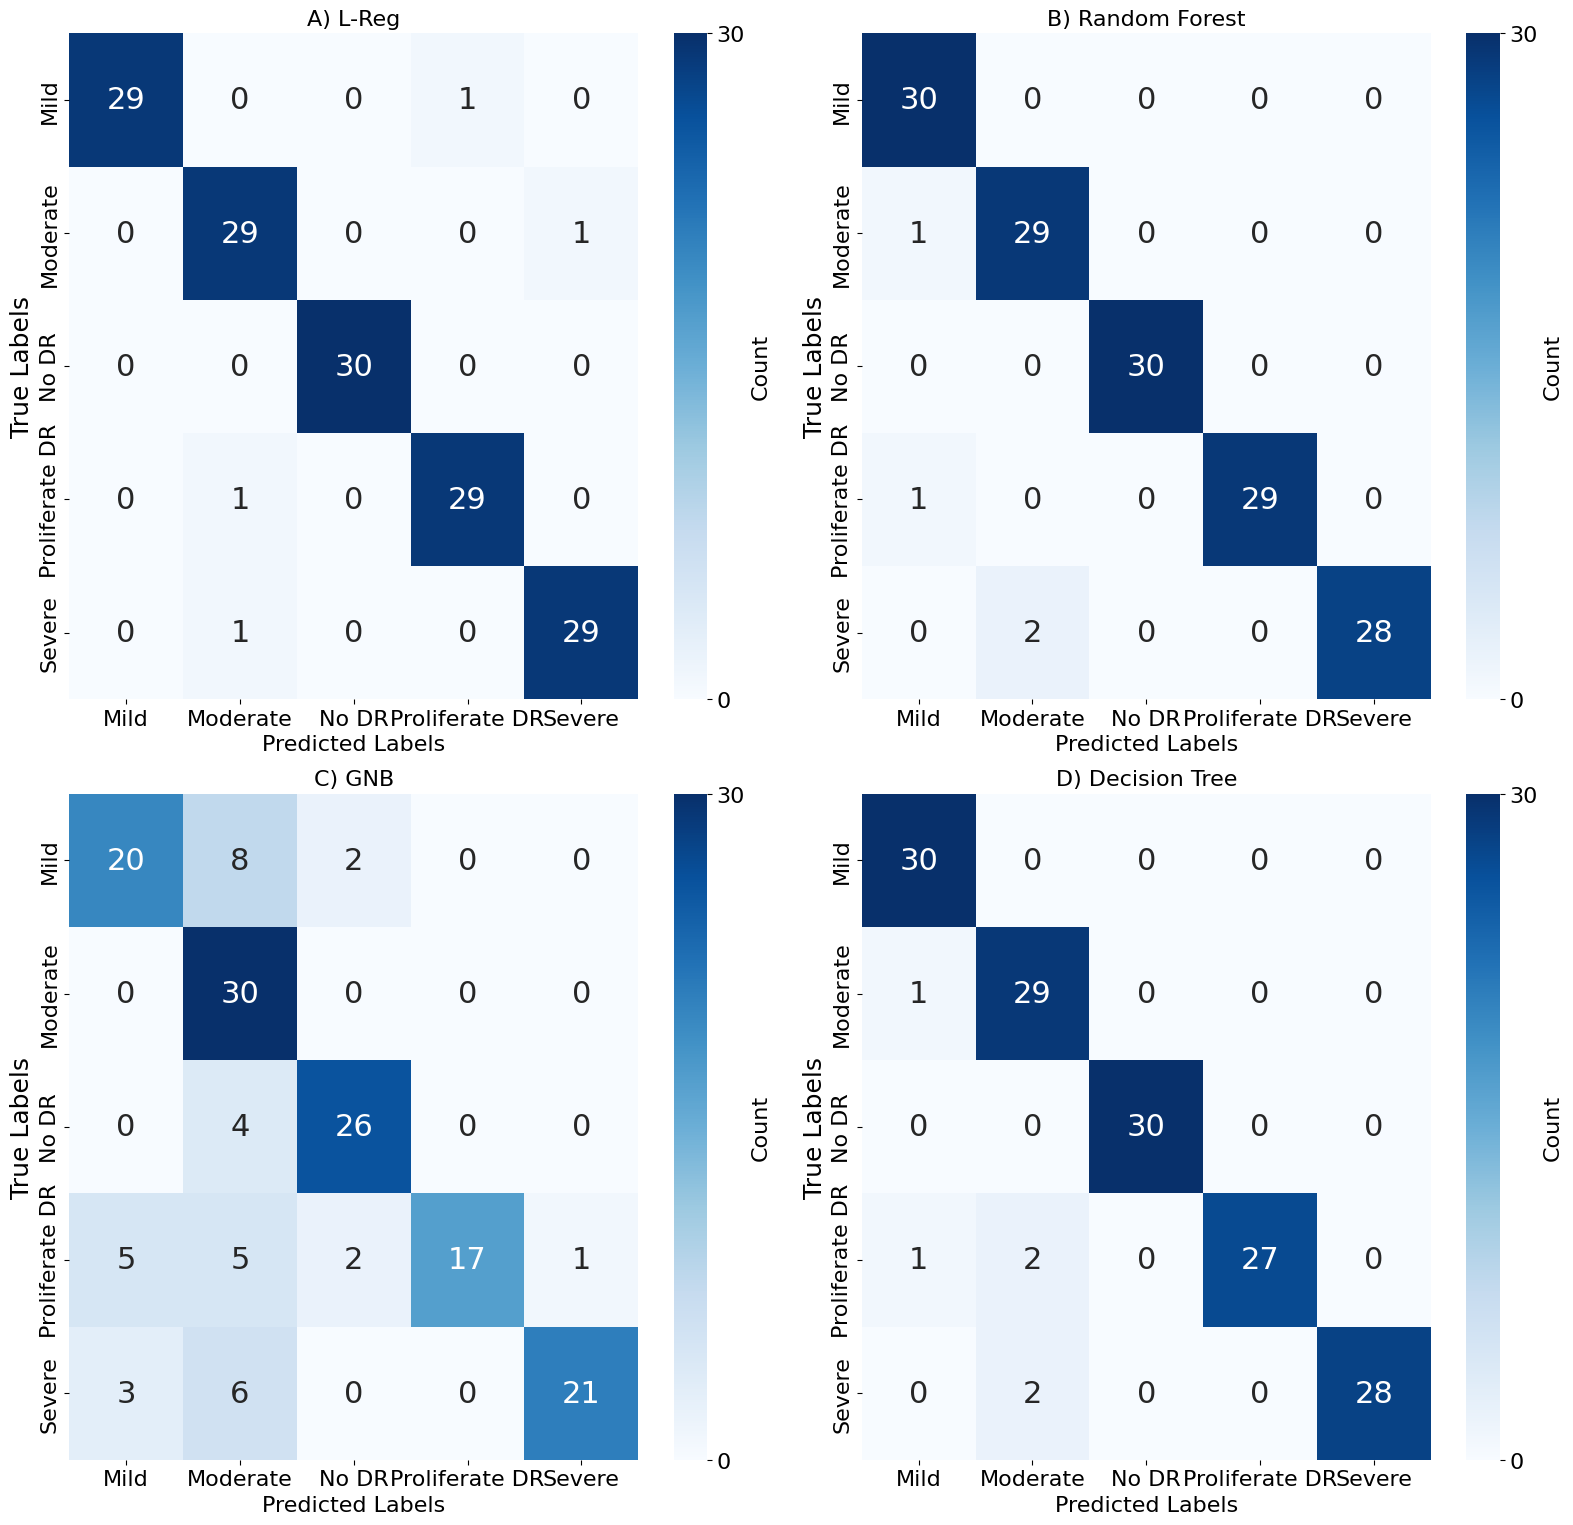

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have already trained your models: clf_svc, clf_rfr, clf_gnb, clf_dtr

# Test data (replace with actual test data)
# y_test = ...
# X_test_combined = ...

# Predictions for each model
y_test_pred_svc = logreg.predict(X_test_combined)
y_test_pred_rfr = rfr.predict(X_test_combined)
y_test_pred_gnb = gnb.predict(X_test_combined)
y_test_pred_dtr = dtr.predict(X_test_combined)

# Confusion matrices for each model
cm_svc = confusion_matrix(y_test, y_test_pred_svc)
cm_rfr = confusion_matrix(y_test, y_test_pred_rfr)
cm_gnb = confusion_matrix(y_test, y_test_pred_gnb)
cm_dtr = confusion_matrix(y_test, y_test_pred_dtr)

# Create the plot with 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(16, 16))


# List of models and corresponding confusion matrices
models = ['A) L-Reg', 'B) Random Forest', 'C) GNB', 'D) Decision Tree']
cms = [cm_svc, cm_rfr, cm_gnb, cm_dtr]

# Class names for the axes
class_names = ['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']
tick_positions = np.arange(len(class_names)) + 0.5  # Centering ticks

for i, ax in enumerate(axs.flat):
    # Create heatmap for each confusion matrix
    sns.heatmap(cms[i], annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count', 'ticks': [0, cms[i].max()]}, ax=ax)

    # Set labels, ticks, and titles
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.set_ylabel('True Labels', fontsize=18)
    ax.set_title(models[i], fontsize=16)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(class_names, fontsize=16)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(class_names, fontsize=16, rotation=90)
    ax.collections[0].colorbar.ax.tick_params(labelsize=16)
    ax.collections[0].colorbar.ax.set_ylabel('Count', fontsize=16)
    # Update font size for annotations
    for text in ax.texts:
        text.set_size(22)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # To prevent overlap with the title
plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train Support Vector Classifier (SVC) model
clf_svc = SVC(probability=True) # Enable probability estimates
clf_svc.fit(X_train_combined, y_train) # Fit using clf_svc

# Evaluate model on test set
y_test_pred = clf_svc.predict(X_test_combined) # Predict using clf_svc
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))

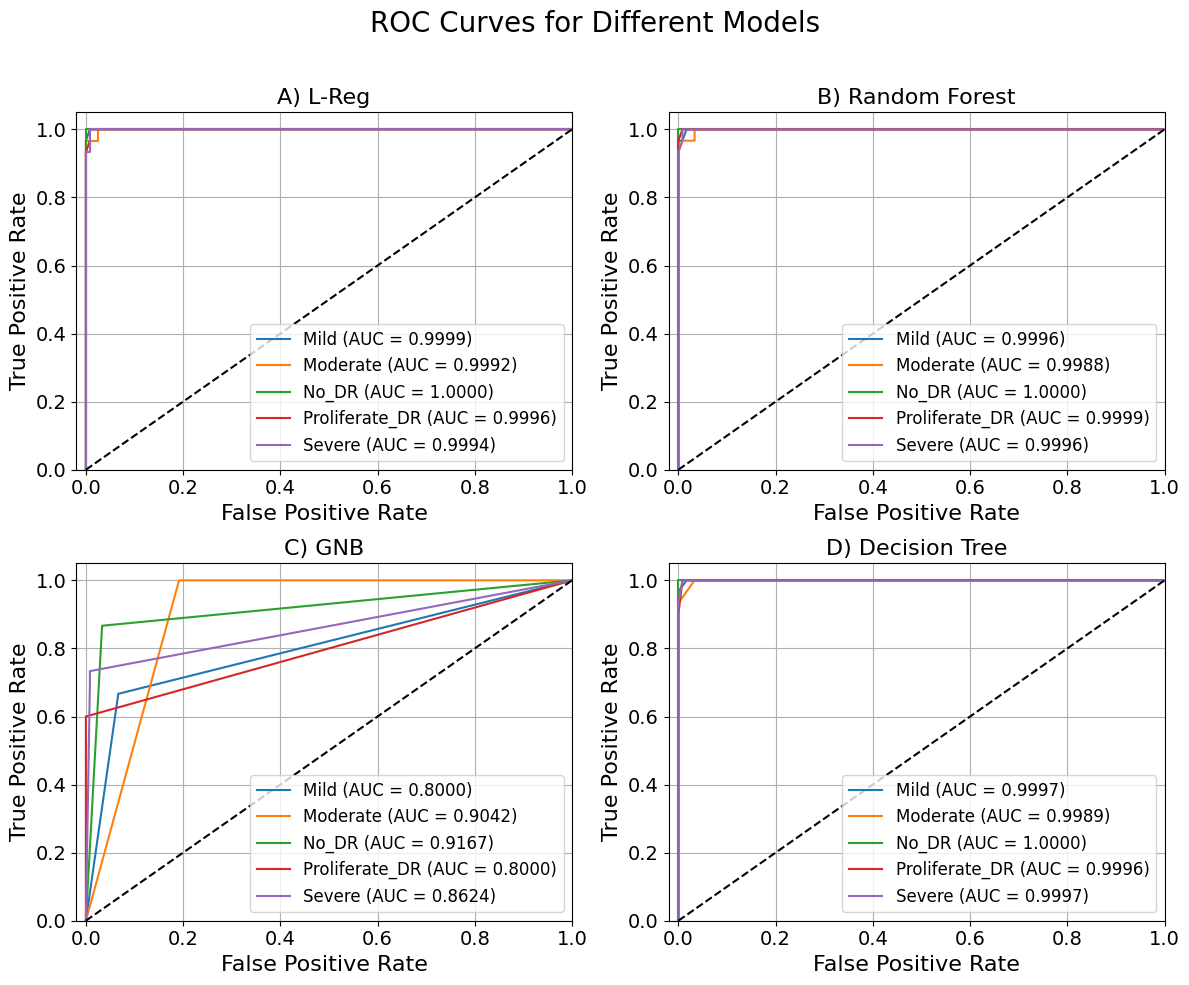

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Assuming you have already trained your models: clf_svc, clf_rfr, clf_gnb, clf_dtr

# Test data (replace with actual test data)
# y_test = ...
# X_test_combined = ...

# Predictions for each model
y_score_svc = logreg.predict_proba(X_test_combined)
y_score_rfr = rfr.predict_proba(X_test_combined)
y_score_gnb = gnb.predict_proba(X_test_combined)
y_score_dtr = dtr.predict_proba(X_test_combined)

# Binarize the labels for ROC curve
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Compute ROC curve and ROC area for each model
fpr_svc, tpr_svc, roc_auc_svc = dict(), dict(), dict()
fpr_rfr, tpr_rfr, roc_auc_rfr = dict(), dict(), dict()
fpr_gnb, tpr_gnb, roc_auc_gnb = dict(), dict(), dict()
fpr_dtr, tpr_dtr, roc_auc_dtr = dict(), dict(), dict()

n_classes = len(lb.classes_)

for i in range(n_classes):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(y_test_bin[:, i], y_score_svc[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])

    fpr_rfr[i], tpr_rfr[i], _ = roc_curve(y_test_bin[:, i], y_score_rfr[:, i])
    roc_auc_rfr[i] = auc(fpr_rfr[i], tpr_rfr[i])

    fpr_gnb[i], tpr_gnb[i], _ = roc_curve(y_test_bin[:, i], y_score_gnb[:, i])
    roc_auc_gnb[i] = auc(fpr_gnb[i], tpr_gnb[i])

    fpr_dtr[i], tpr_dtr[i], _ = roc_curve(y_test_bin[:, i], y_score_dtr[:, i])
    roc_auc_dtr[i] = auc(fpr_dtr[i], tpr_dtr[i])

# Plot ROC curves for each model in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('ROC Curves for Different Models', fontsize=20)

# List of model names and corresponding ROC values
models = ['A) L-Reg', 'B) Random Forest', 'C) GNB', 'D) Decision Tree']
fprs = [fpr_svc, fpr_rfr, fpr_gnb, fpr_dtr]
tprs = [tpr_svc, tpr_rfr, tpr_gnb, tpr_dtr]
roc_aucs = [roc_auc_svc, roc_auc_rfr, roc_auc_gnb, roc_auc_dtr]

for i, ax in enumerate(axs.flat):
    # Plot the ROC curve for each class in the current model
    for j in range(n_classes):
        ax.plot(fprs[i][j], tprs[i][j], label=f'{lb.classes_[j]} (AUC = {roc_aucs[i][j]:.4f})')

    # Add random guessing line (diagonal)
    ax.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    ax.set_xlim([-0.02, 1.0])  # Set limit of X ticks
    ax.set_ylim([0.0, 1.05])  # Set limit of Y ticks
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    ax.set_title(models[i], fontsize=16)
    ax.grid(True)
    ax.legend(loc="lower right", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()



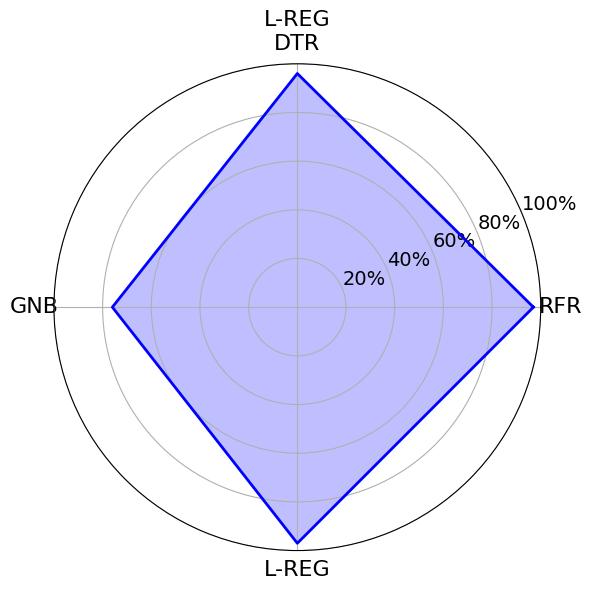

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the models and their accuracies
models = ['RFR', 'DTR', 'GNB', 'L-REG']
accuracies = [97, 96, 76, 97]  # Test accuracies in percentage

# Number of variables (models)
num_vars = len(models)

# Compute angle for each model (equally spaced in the radar plot)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Ensure the plot is a closed loop
accuracies += accuracies[:1]  # Repeat the first accuracy at the end
angles += angles[:1]          # Repeat the first angle at the end

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot the data
ax.fill(angles, accuracies, color='blue', alpha=0.25)
ax.plot(angles, accuracies, color='blue', linewidth=2)

# Add labels for each model
ax.set_yticks([20, 40, 60, 80, 100])  # Define y-axis ticks
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=14)
ax.set_xticks(angles[:-1])  # Skip the last angle (repeated)
ax.set_xticklabels(models, fontsize=16)
ax.set_title(models[i], fontsize=16)
# Title and grid

ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


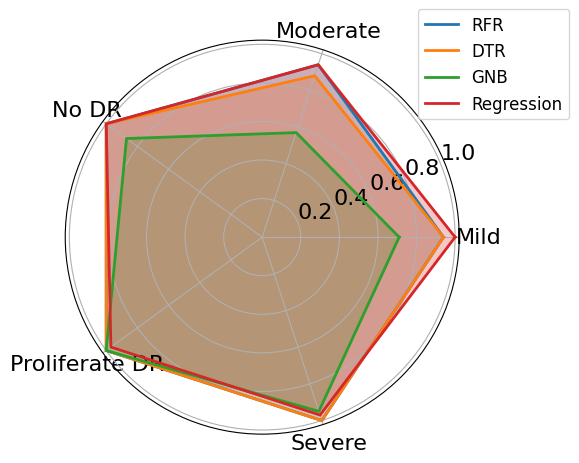

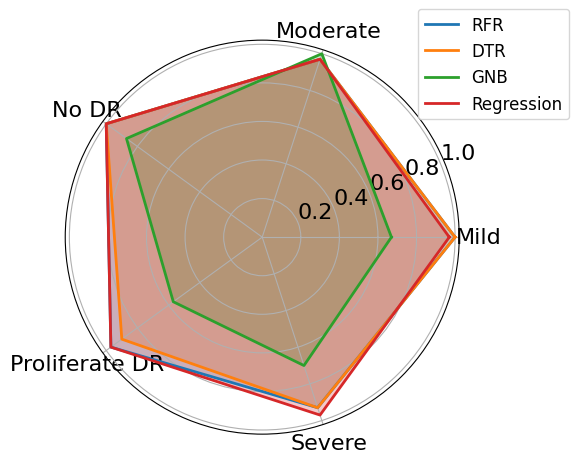

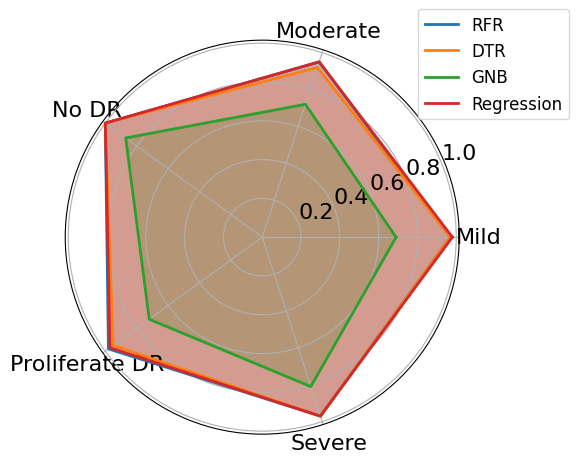

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define models and metrics
models = ['RFR', 'DTR', 'GNB', 'Regression']
classes = ['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']

# Metrics for each class per model
precision = [
    [0.94, 0.94, 1.00, 1.00, 1.00],  # RFR
    [0.94, 0.88, 1.00, 1.00, 1.00],  # DTR
    [0.71, 0.57, 0.87, 1.00, 0.95],  # GNB
    [1.00, 0.94, 1.00, 0.97, 0.97]   # Regression
]

recall = [
    [1.00, 0.97, 1.00, 0.97, 0.93],  # RFR
    [1.00, 0.97, 1.00, 0.90, 0.93],  # DTR
    [0.67, 1.00, 0.87, 0.57, 0.70],  # GNB
    [0.97, 0.97, 1.00, 0.97, 0.97]   # Regression
]

f1_score = [
    [0.97, 0.95, 1.00, 0.98, 0.97],  # RFR
    [0.97, 0.92, 1.00, 0.95, 0.97],  # DTR
    [0.69, 0.72, 0.87, 0.72, 0.81],  # GNB
    [0.98, 0.95, 1.00, 0.97, 0.97]   # Regression
]

# Function to create radar plot
def create_radar_plot(metrics, title):
    num_classes = len(classes)
    angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for i, model_metrics in enumerate(metrics):
        values = model_metrics + model_metrics[:1]  # Close the loop
        ax.plot(angles, values, label=models[i], linewidth=2)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=16)  # Y ticks font size
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes, fontsize=16)  # X ticks font size

    ax.set_title(title, fontsize=16, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
    plt.tight_layout()
    plt.show()

# Create radar plots for each metric
create_radar_plot(precision, "")
create_radar_plot(recall, "")
create_radar_plot(f1_score, "")



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Train Decision Tree model
dtr = DecisionTreeClassifier(random_state=42)
dtr.fit(X_train_combined, y_train)

# Evaluate model on test set
y_test_pred = dtr.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))


NameError: name 'X_train_combined' is not defined

Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.94      1.00      0.97        30
      Moderate       0.88      0.97      0.92        30
         No DR       1.00      1.00      1.00        30
Proliferate DR       1.00      0.90      0.95        30
        Severe       1.00      0.93      0.97        30

      accuracy                           0.96       150
     macro avg       0.96      0.96      0.96       150
  weighted avg       0.96      0.96      0.96       150



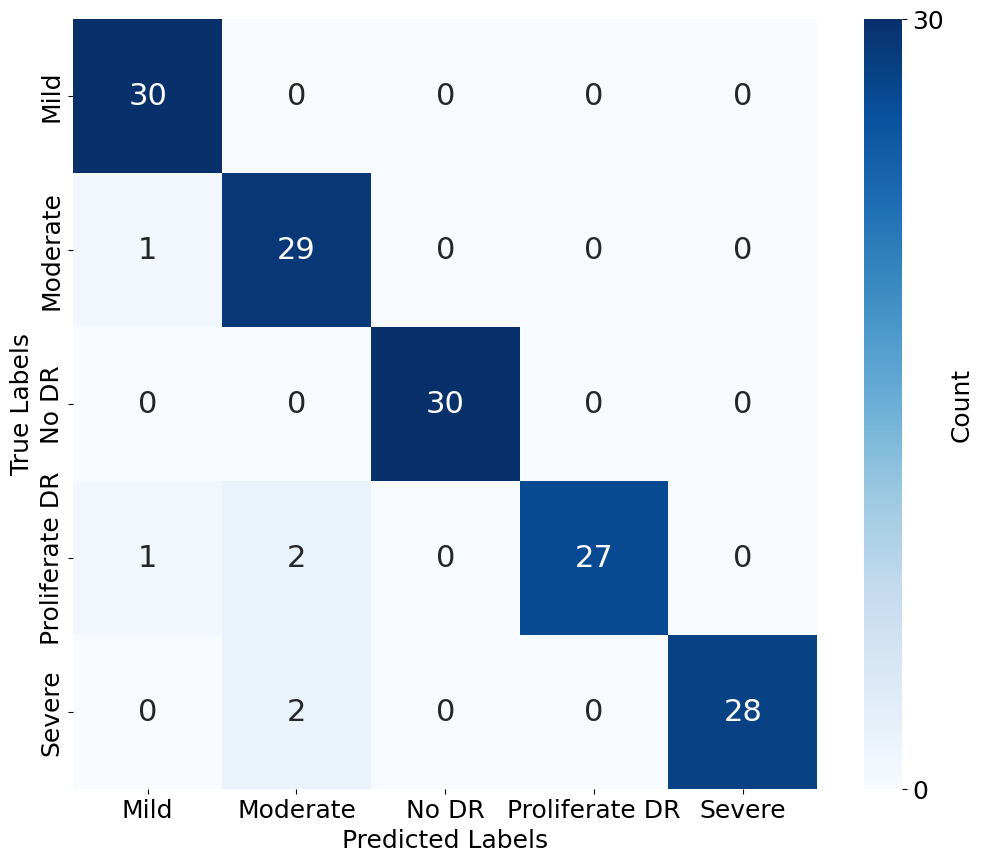

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model on test set
y_test_pred = dtr.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count', 'ticks': [0, cm.max()]})

# Set font sizes and rotations
plt.xlabel("Predicted Labels", fontsize=18)
plt.ylabel("True Labels", fontsize=18)

# Center the tick labels
class_names = ['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']
tick_positions = np.arange(len(class_names)) + 0.5  # Shift ticks to the center of each cell

plt.xticks(ticks=tick_positions, labels=class_names, fontsize=18)
plt.yticks(ticks=tick_positions, labels=class_names, fontsize=18, rotation=90)

# Update the font size for annotations
for text in heatmap.texts:
    text.set_size(22)

# Set color bar tick size
heatmap.collections[0].colorbar.ax.tick_params(labelsize=18)
heatmap.collections[0].colorbar.ax.set_ylabel('Count', fontsize=18)

plt.show()

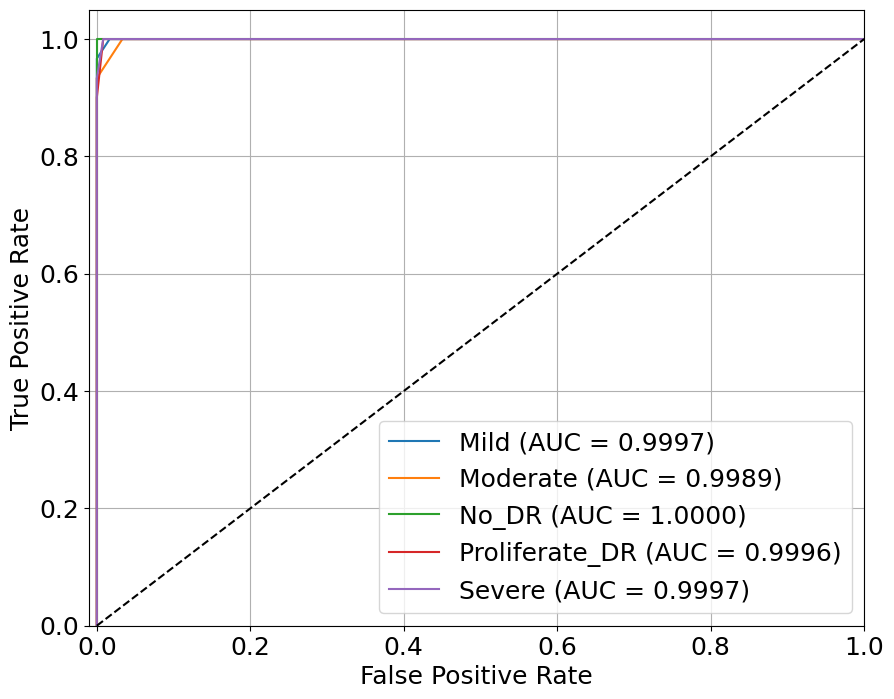

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc # Import roc_curve and auc

# Binarize the labels for ROC curve
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = dtr.predict_proba(X_test_combined)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(lb.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{lb.classes_[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([-0.01, 1.0]) # Set limit of X ticks
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(loc="lower right",fontsize=18)
plt.show()

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Train Gaussian Naive Bayes (GNB) model
gnb = GaussianNB()
gnb.fit(X_train_combined, y_train)

# Evaluate model on test set
y_test_pred = gnb.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))


Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.71      0.67      0.69        30
      Moderate       0.57      1.00      0.72        30
         No DR       0.87      0.87      0.87        30
Proliferate DR       1.00      0.57      0.72        30
        Severe       0.95      0.70      0.81        30

      accuracy                           0.76       150
     macro avg       0.82      0.76      0.76       150
  weighted avg       0.82      0.76      0.76       150



Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.71      0.67      0.69        30
      Moderate       0.57      1.00      0.72        30
         No DR       0.87      0.87      0.87        30
Proliferate DR       1.00      0.57      0.72        30
        Severe       0.95      0.70      0.81        30

      accuracy                           0.76       150
     macro avg       0.82      0.76      0.76       150
  weighted avg       0.82      0.76      0.76       150



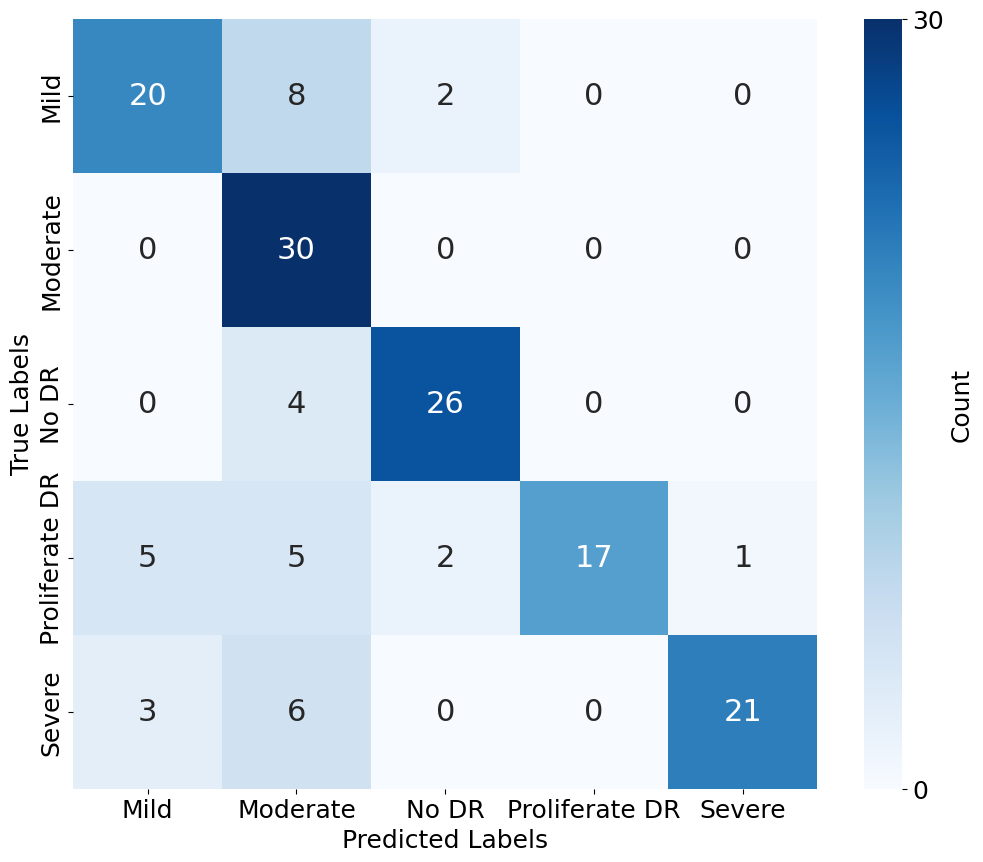

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model on test set
y_test_pred = gnb.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count', 'ticks': [0, cm.max()]})

# Set font sizes and rotations
plt.xlabel("Predicted Labels", fontsize=18)
plt.ylabel("True Labels", fontsize=18)

# Center the tick labels
class_names = ['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']
tick_positions = np.arange(len(class_names)) + 0.5  # Shift ticks to the center of each cell

plt.xticks(ticks=tick_positions, labels=class_names, fontsize=18)
plt.yticks(ticks=tick_positions, labels=class_names, fontsize=18, rotation=90)

# Update the font size for annotations
for text in heatmap.texts:
    text.set_size(22)

# Set color bar tick size
heatmap.collections[0].colorbar.ax.tick_params(labelsize=18)
heatmap.collections[0].colorbar.ax.set_ylabel('Count', fontsize=18)

plt.show()

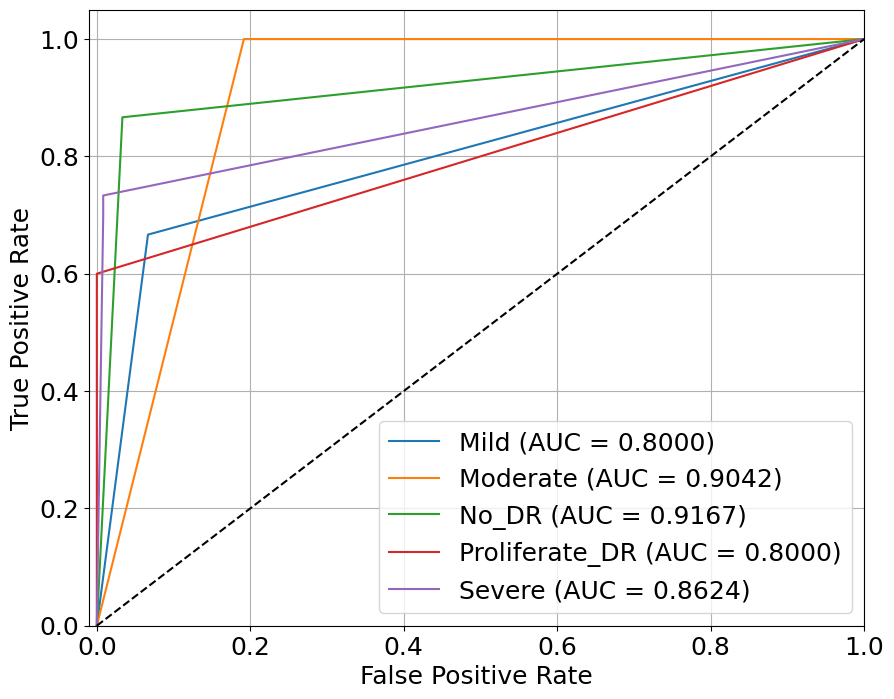

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc # Import roc_curve and auc

# Binarize the labels for ROC curve
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = gnb.predict_proba(X_test_combined)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(lb.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{lb.classes_[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([-0.01, 1.0]) # Set limit of X ticks
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(loc="lower right",fontsize=18)
plt.show()

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 13.8 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Train XGBoost model
from catboost import CatBoostClassifier
catboost = CatBoostClassifier(iterations=100, random_state=42, learning_rate=0.1, depth=6)
catboost.fit(X_train_combined, y_train)

# Evaluate model on test set
y_test_pred = catboost.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))

NameError: name 'X_train_combined' is not defined